In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F

In [11]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 reduction followed by 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 reduction followed by 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        # Apply each branch
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # Concatenate all the branches along the channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return outputs

In [12]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogleNet, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Initial layers
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)

        # Inception layers
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        # Final layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize to fit AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = random_split(train_dataset, [0.9, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=256, shuffle=True)

Files already downloaded and verified


In [15]:
# Initialize model, loss function, and optimizer
model = GoogleNet(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 20
losses=[]
accs=[]
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for idx,(images, labels) in enumerate(train_loader):#train
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if(idx % 50 == 0):
          print(f'batch:{idx} , batch loss:{loss.item()}\n')
        total_loss += loss.item()

    acc=0
    for idx,(images, labels) in enumerate(val_loader): #validation
        images, labels = images.to(device), labels.to(device)
        outputs = torch.argmax(model(images),dim=1)
        comp=torch.eq(labels,outputs).float().to('cpu')
        acc+=torch.sum(comp)/len(comp)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Total loss: {total_loss / len(train_loader):.4f} , Accuracy : {(acc/(idx+1))*100} %')
    losses.append(total_loss / len(train_loader))
    accs.append((acc/(idx+1))*100)
print("Training complete!")

batch:0 , batch loss:2.3039140701293945

batch:50 , batch loss:2.3677685260772705

batch:100 , batch loss:2.1532270908355713

batch:150 , batch loss:2.043086051940918

Epoch [1/20], Total loss: 2.2514 , Accuracy : 26.36488914489746 %
batch:0 , batch loss:1.8619985580444336

batch:50 , batch loss:1.7485344409942627

batch:100 , batch loss:1.6307730674743652

batch:150 , batch loss:1.67820405960083

Epoch [2/20], Total loss: 1.7305 , Accuracy : 37.03125 %
batch:0 , batch loss:1.726747989654541

batch:50 , batch loss:1.5483412742614746

batch:100 , batch loss:1.349151372909546

batch:150 , batch loss:1.475553035736084

Epoch [3/20], Total loss: 1.4873 , Accuracy : 49.836856842041016 %
batch:0 , batch loss:1.3881158828735352

batch:50 , batch loss:1.2317118644714355

batch:100 , batch loss:1.3327429294586182

batch:150 , batch loss:1.1373780965805054

Epoch [4/20], Total loss: 1.2744 , Accuracy : 58.242191314697266 %
batch:0 , batch loss:1.1049374341964722

batch:50 , batch loss:1.07062447

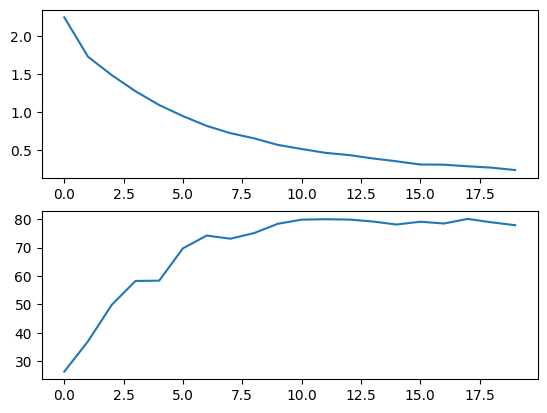

In [17]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(losses)
plt.subplot(2,1,2)
plt.plot(accs)
plt.show()